In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

import matplotlib.pyplot as plt
import seaborn as sns

# Import Datasets

In [2]:
df = pd.read_csv("datasets/train.csv", index_col="id")
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
4,1,0,0,1,6,1,5,0,0,1,...,0,1,2,0,0,0,0,0,0,Class_1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


Karena dataframe memiliki kolom yang sangat banyak, yaitu berjumlah 93 kolom. Dan, kolom tersebut bersifat abstrak kita tidak dapat mengetahui makna kolomnya. Oleh karena itu, kita melakukan teknik dalam unsupervised yaitu PCA supaya jumlah kolom dapat berkurang, dan proses komputasi juga tidak terlalu berat.
### Cek Balance atau tidaknya data target.

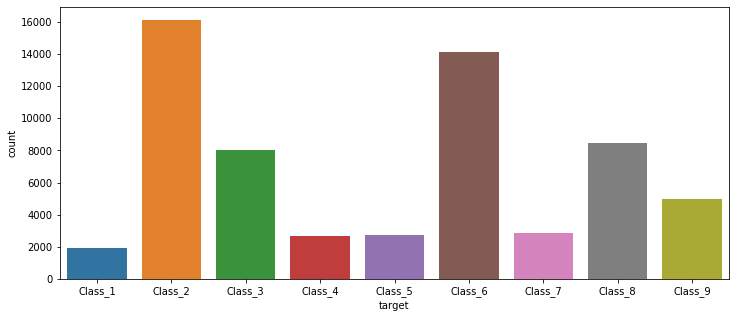

In [3]:
plt.figure(figsize=(12, 5))
ax = sns.countplot(x=df["target"])

### Datasets Splitting.
kita pecah dataframe tersebut menjadi empat data sebagai data training dan data test.

In [4]:
X = df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49502, 93), (12376, 93), (49502,), (12376,))

### Kita gunakan PCA untuk mengurangi kolom, namun tetap mempertahankan makna-makna yang ada di dalam kolom yang sebenarnya.

In [5]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

Text(0, 0.5, 'Comulative explained variance')

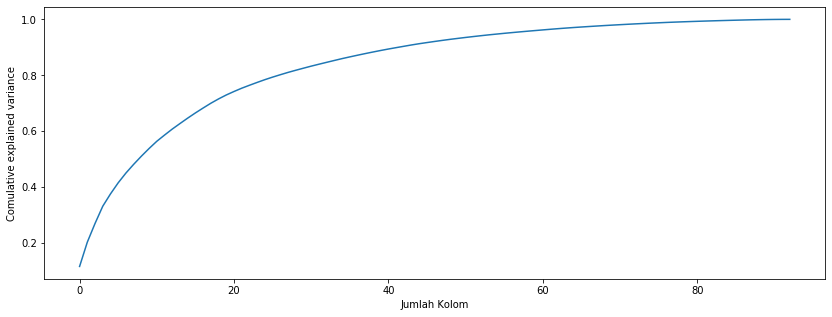

In [6]:
# buat variabel pca untuk menampung PCA dan sekaligus melakukan training pada X_train
pca = PCA().fit(X_train)

plt.figure(figsize=(14, 5))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("Jumlah Kolom")
plt.ylabel("Comulative explained variance")

Berdasarkan grafik di atas, kita akan mencoba mengurangi kolom menjadi 82 kolom.
## Random Forest Classifier
kita akan mencoba menggunakan algoritma random forest untuk modeling.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [8]:
preprocessor = ColumnTransformer([
    # Karena semua kolom adalah data kategoric
    ('categoric', cat_pipe(encoder='onehot'), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    
    # tambahkan SVD sebelum masuk algoritma
    #('svd', TruncatedSVD(n_iter=7, random_state=42)),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

In [9]:
parameter = {
    #'svd__n_components' : [82],
    'algo__n_estimators': [100, 150, 200],
    'algo__max_depth': [20, 50, 80],
    'algo__max_features': [0.3, 0.6, 0.8],
    'algo__min_samples_leaf': [1, 5, 10]
}

In [ ]:
model = GridSearchCV(pipeline, parameter, cv=3, scoring="f1", n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))
print("\nNilai Akurasi Pada Data Train:", model.score(X_train, y_train))
print("Nilai Akurasi Pada Data Test:", model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
